<a href="https://colab.research.google.com/github/EmilioMobile/AUTH-MICROSERVICE/blob/master/MXNET_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install mxnet-cu80
!pip install mxnet


In [2]:
import os
import sys
import tarfile
import time
import zipfile
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils as gutils
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

# check if we have GPU available
def try_gpu4():
  try:
    ctx = mx.gpu()
    _ = nd.zeros((1,), ctx=ctx)
  except mx.base.MXNetError:
    ctx = mx.cpu()
  return ctx

model_ctx = try_gpu4()
model_ctx

cpu(0)

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.mxnet', 'datasets', 'fashion-mnist')):
    """Download the fashion mnist dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [gdata.vision.transforms.Resize(resize)]
    transformer += [gdata.vision.transforms.ToTensor()]
    transformer = gdata.vision.transforms.Compose(transformer)

    mnist_train = gdata.vision.FashionMNIST(root=root, train=True)
    mnist_test = gdata.vision.FashionMNIST(root=root, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter, mnist_train

#### Model, LeNet

In [0]:
def create_network():
  net = nn.Sequential()
  net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
         nn.AvgPool2D(pool_size=2, strides=2), 
         nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
         nn.AvgPool2D(pool_size=2, strides=2),
         nn.Dense(120, activation='sigmoid'),
         nn.Dense(84, activation='sigmoid'),
         nn.Dense(10))
  #for layer in net:
  #  print(layer.name, 'output shape:\t', X.shape)
  return net

#### Data Acquisition


In [0]:
batch_size = 100
train_data, test_data, train_dataset = load_data_fashion_mnist(batch_size=batch_size)

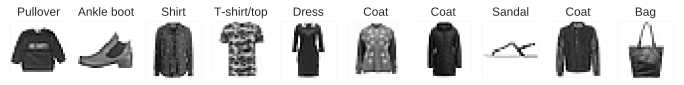

In [6]:
from IPython import display

def show_fashion_mnist(images, labels):
    """Plot Fashion-MNIST images with labels."""
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')
    
    label_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}    
    
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.set_title(label_desc[lbl])
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

def get_fashion_mnist_labels(labels):
    """Get text label for fashion mnist."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

images = []
labels = []

for i in range(10): # len(x))
  sample = train_dataset[i]
  images.append(sample[0])
  labels.append(sample[1])
  
show_fashion_mnist(images, labels)
#get_fashion_mnist_labels(labels)

#### Transform , Preprocessing

In [0]:
# Normalize, Standardize, Feature scaling
# http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html
# https://www.quora.com/What-are-the-best-data-normalization-methods-before-giving-to-Neural-Nets-or-Deep-Learning-algorithm

# rescale 
def transform(data, label):
  return data.astype(np.float32)/255, label.astype(np.float32)

#### Training

In [0]:
def evaluate_accuracy(data_iterator, net):
          accuracy = mx.metric.Accuracy()
          for data, label in data_iterator:
              data = data.as_in_context(model_ctx) #.reshape((-1, num_inputs))
              label = label.as_in_context(model_ctx)
              output = net(data)
              predictions = nd.argmax(output, axis=1)
              accuracy.update(preds=predictions, labels=label)
          return accuracy.get()[1]


In [0]:
epochs = 5

fig = plt.figure(figsize=(20, 9))
train_plot = fig.add_subplot(1, 2, 1)
test_plot = fig.add_subplot(1, 2, 2)

final_accuracy = {}

optimizers = [
    ('sgd', {'learning_rate': 0.1}, 'red', 'sgd'),
  #  ('sgd', {'learning_rate': 0.2, 'momentum': 0.9 }, 'blue', 'sgd-momentum'),
  #  ('adagrad', {'learning_rate': 0.9}, 'green', 'adagrad'),
  #  ('rmsprop', {'learning_rate': 0.03, 'gamma1': 0.9}, 'orange', 'rmsprop'),
  #  ('adadelta', {'rho': 0.9999}, 'black', 'adadelta')
]

picture_size_pixels = 28
num_inputs = picture_size_pixels * picture_size_pixels
num_outputs = 10

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

for optimizer in optimizers:
    name, params, color, key = optimizer
 
    net = create_network()
  
    # Initialize the parameters with Xavier initializer
    net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
  
    trainer = gluon.Trainer(net.collect_params(), name, params)
    
    # Collecting intermediate epoch accuracies
    test_accuracy = []
    train_accuracy = []

    for e in range(epochs):
      
        n, start = 0, time.time()

        for batch_num, (data, label) in enumerate(train_data):
            data = data.as_in_context(model_ctx)
            label = label.as_in_context(model_ctx)
            # Ask autograd to record the forward pass
            with autograd.record():
                # Run the forward pass
                output = net(data)
                # Compute the loss
                loss = softmax_cross_entropy(output, label)
            # Compute gradients
            loss.backward()
            # Update parameters
            trainer.step(batch_size)
            
            # Print loss once in a while
            if batch_num % 1000 == 0:
                curr_loss = nd.mean(loss).asscalar()
                print("Epoch: %d; Batch %d; Loss %f" % (e, batch_num, curr_loss))
            
        train_accuracy.append(evaluate_accuracy(train_data, net))
        test_accuracy.append(evaluate_accuracy(test_data, net))
    
    # Plotting some results
    y_ticks = [e + 1 for e in range(epochs)]
    x_ticks = np.arange(0.75, 1.0, 0.05)
    def create_plot(line_plot, data, kind):
        line_plot.plot(data, y_ticks, c=color, label=key)
        line_plot.legend(loc='upper left')
        line_plot.set_title("Model's {} prediction accuracy trends".format(kind))
        line_plot.set_xlabel('Accuracy')
        line_plot.set_xticks(x_ticks)
        line_plot.set_ylabel('Epochs')
        line_plot.set_yticks(y_ticks)

    create_plot(train_plot, train_accuracy, 'train')
    create_plot(test_plot, test_accuracy, 'test')

    # Aggregate results to summarize later
    final_accuracy[key] = (train_accuracy, test_accuracy)

plt.show()

Epoch: 0; Batch 0; Loss 2.504886
Epoch: 0; Batch 50; Loss 2.292763
Epoch: 0; Batch 100; Loss 2.303300
Epoch: 0; Batch 150; Loss 2.322736
Epoch: 0; Batch 200; Loss 2.306874
Epoch: 0; Batch 250; Loss 2.317914
Epoch: 0; Batch 300; Loss 2.300663
Epoch: 0; Batch 350; Loss 2.305336
Epoch: 0; Batch 400; Loss 2.317142
Epoch: 0; Batch 450; Loss 2.309135
Epoch: 0; Batch 500; Loss 2.304113
Epoch: 0; Batch 550; Loss 2.295514
Epoch: 1; Batch 0; Loss 2.298165
Epoch: 1; Batch 50; Loss 2.302648
Epoch: 1; Batch 100; Loss 2.318282


#### Summary

In [11]:
# Summary Accuracies
for name, acc in final_accuracy.items():
          print('Optimizer: "{}"'.format(name))
          train, test = acc
          for i in range(epochs):
              print('Train accuracy: {:.2%}, Test accuracy: {:.2%}'.format(train[i], test[i]))

Optimizer: "sgd"
Train accuracy: 70.27%, Test accuracy: 69.97%
Train accuracy: 77.25%, Test accuracy: 77.29%
Train accuracy: 80.47%, Test accuracy: 80.99%
Train accuracy: 83.48%, Test accuracy: 83.69%
Train accuracy: 84.86%, Test accuracy: 85.02%


#### Saving model parameters to file

In [0]:
file_name = "net.params"
net.save_parameters(file_name)

https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/save_load_params.html
https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/mnist.html
https://github.com/mli/gluon-crash-course/blob/master/predict.md

#### Predict

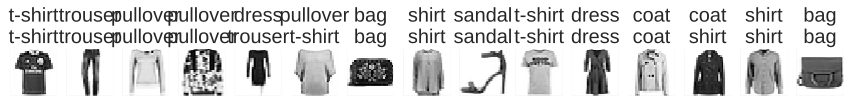

In [37]:
from mxnet.gluon.data.vision import datasets, transforms

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_valid = gdata.vision.FashionMNIST(train=False)

items = 15

X, y = mnist_valid[:items]
preds = []  
for x in X:
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())
    
_, figs = plt.subplots(1, items, figsize=(15, 15))
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
for f,x,yi,pyi in zip(figs, X, y, preds):
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#show_fashion_mnist(images, labels)
#get_fashion_mnist_labels(labels)